In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython
import time
from torch.utils.data import Dataset
import random
import torch
import torchaudio
from torch.utils.data import DataLoader
from randomDataset import RandomDataset
import sys
#sys.path.append("..")
from utils.cnn import CNNNetwork
from utils.lstm import LSTMNetwork
from utils import LABELS
from utils.numpyDataset import NumpyDataset
print(LABELS)
#from pydub import AudioSegment

['Amos', 'Kailash', 'Cyprian', 'Selena', 'Aneri', 'Dylan', 'Jennifer']


In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
loss = torch.nn.CrossEntropyLoss()

src = 'speeches'
nfft=512
nmels=60
mfcc = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=15, melkwargs={'n_fft':nfft, 'n_mels':nmels})

#dataSet = RandomDataset(src, 16000, 1000, mfcc, 6, 5)

dataSet = NumpyDataset("./trainX_denoised_8.npy", "./trainY_denoised_8.npy")
train_data, val_data = torch.utils.data.random_split(dataSet, (55000, 5001))
input_shape = dataSet[0][0]
train_dl = DataLoader(train_data, batch_size=64)
val_dl = DataLoader(val_data, batch_size=64)

# fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
# for i in range(3):
#     img, label = val_data[i]
#     if i==0:
#         print('shape of feature:', img.shape)
#         print('datatype', img.dtype)
#         input_shape = img.shape
#     axs[i].imshow(img[0].cpu(), origin='lower')
#     axs[i].set_title(f'label: {label}')
print(input_shape)

cuda
[[0.8847656  0.56933594 0.953125   ... 0.06054688 0.06054688 0.06054688]
 [0.42382812 0.5751953  0.72753906 ... 0.5058594  0.5058594  0.5058594 ]
 [0.8378906  0.04199219 0.8173828  ... 0.7675781  0.7675781  0.7675781 ]
 ...
 [0.93359375 0.84765625 0.57421875 ... 0.9628906  0.9628906  0.9628906 ]
 [0.640625   0.5283203  0.484375   ... 0.9785156  0.87890625 0.9785156 ]
 [0.6816406  0.11523438 0.45898438 ... 0.95214844 0.5058594  0.95214844]]


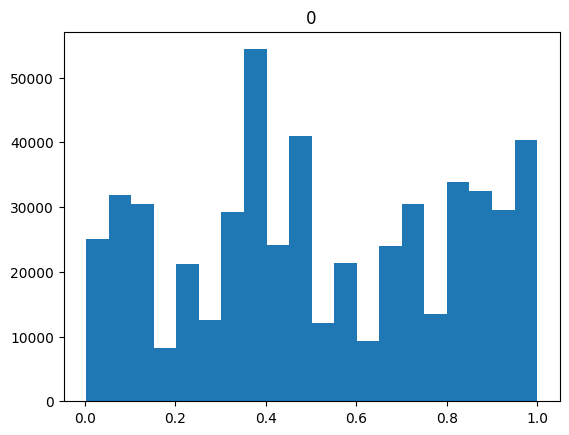

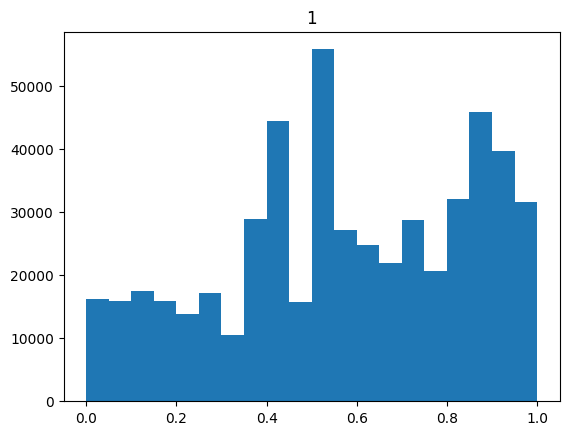

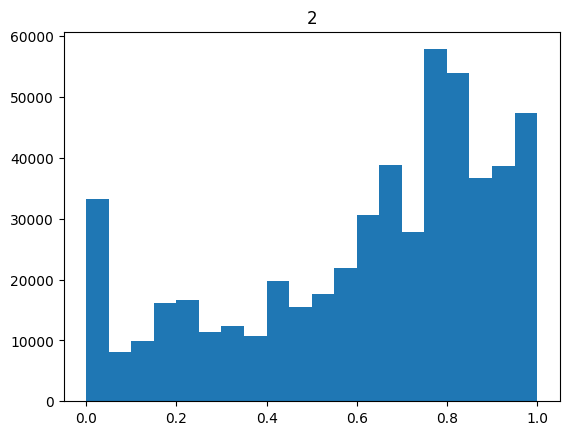

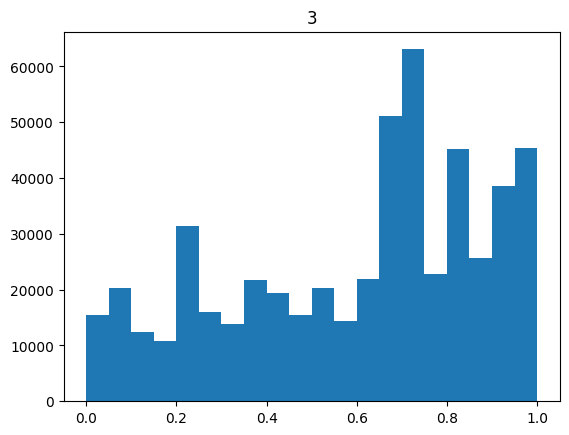

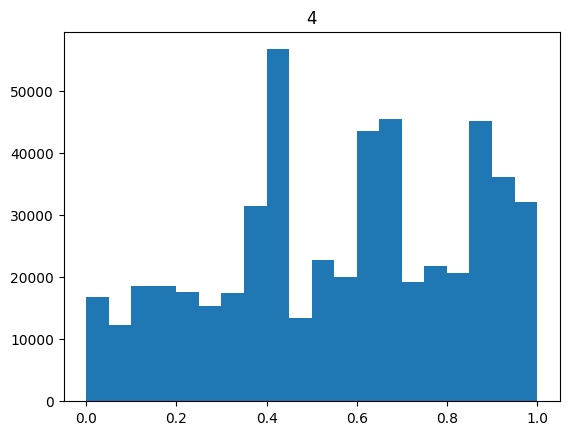

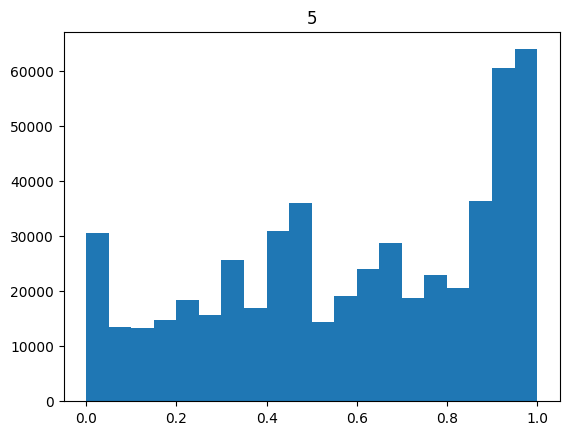

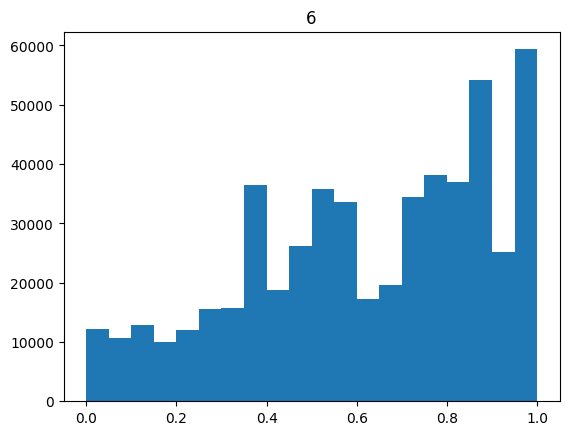

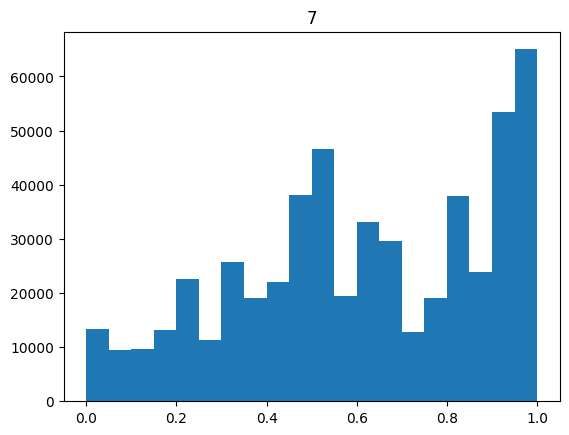

In [21]:
sample0 = train_data[0][0]
codec_nums = [[] for i in range(len(sample0))]
for i in range(1000):
    sample = train_data[i][0]
    for j in range(len(sample)):
        codec_nums[j] = np.append(codec_nums[j], sample[j])

for i in range(len(sample0)):
    plt.hist(codec_nums[i], bins = 20)
    plt.title(i)
    plt.show()

In [45]:
model = CNNNetwork(out_neurons=7, input_shape=(1, 8, 525), layers=[8, 16, 32, 64])
# model = CNNNetwork(out_neurons=7, input_shape=(1, 16, 375), layers=[8, 16, 32, 64])
#model = LSTMNetwork(input_dim=16, hidden_dim=32, lstm_layers=1, linear_layers=[16, 7])
model.forward(torch.rand((64, 1, 8, 525)))

model = model.to(device)
print(model)

model.forward(rand_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()

545792
torch.Size([64, 1, 8, 525])
torch.Size([64, 8, 5, 263])
torch.Size([64, 16, 3, 132])
torch.Size([64, 32, 2, 67])
torch.Size([64, 64, 2, 34])
CNNNetwork(
  (conv_layer0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten)

In [46]:
def train_epoch(model, train_data_loader, val_data_loader, loss_fn, opt, device, metrics):

    model.train()
    losses = []
    accuracies = []
    for input, target in train_data_loader:
        input, target = input.to(device), target.to(device)

        # calculate loss
        prediction = model(input.unsqueeze(1))
        
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
        # backpropagate error and update weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    metrics['t_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['t_loss'].append((sum(losses)/sum(accuracies)).cpu())
    
    model.eval()
    losses = []
    accuracies = []
    for input, target in val_data_loader:
        input, target = input.to(device), target.to(device)
        prediction = model(input.unsqueeze(1))
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
    
    metrics['v_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['v_loss'].append((sum(losses)/sum(accuracies)).cpu())

****** STARTING TRAINING ******
Finished epoch: 0 Val loss: 2.9692864418029785
Finished epoch: 1 Val loss: 2.1359105110168457
Finished epoch: 2 Val loss: 1.957650065422058
Finished epoch: 3 Val loss: 1.8459177017211914
Finished epoch: 4 Val loss: 1.7810759544372559
Finished epoch: 5 Val loss: 1.7441890239715576
Finished epoch: 6 Val loss: 1.713947057723999
Finished epoch: 7 Val loss: 1.6983258724212646
Finished epoch: 8 Val loss: 1.6835190057754517
Finished epoch: 9 Val loss: 1.6693332195281982
Finished epoch: 10 Val loss: 1.6641887426376343
Finished epoch: 11 Val loss: 1.6533730030059814
Finished epoch: 12 Val loss: 1.6424994468688965
Finished epoch: 13 Val loss: 1.6325666904449463
Finished epoch: 14 Val loss: 1.6256763935089111
Finished epoch: 15 Val loss: 1.617693305015564
Finished epoch: 16 Val loss: 1.614267110824585
Finished epoch: 17 Val loss: 1.6048332452774048
Finished epoch: 18 Val loss: 1.5991655588150024
Finished epoch: 19 Val loss: 1.5906901359558105
Finished epoch: 20 Val

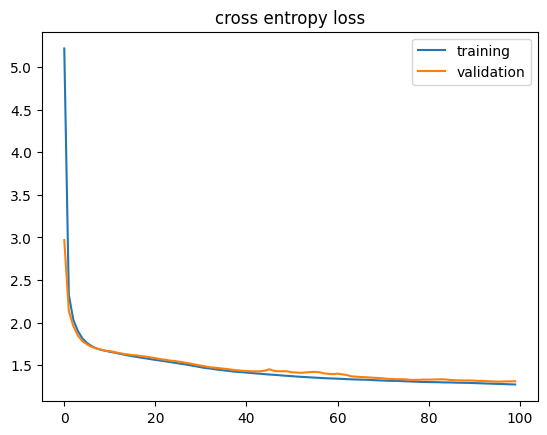

Text(0.5, 1.0, 'accuracy')

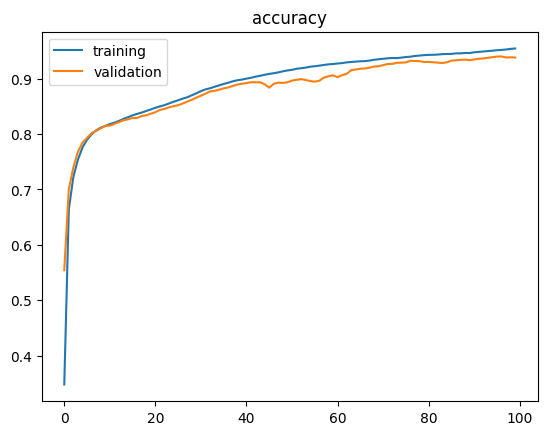

In [47]:
metrics = {
    't_loss': [],
    'v_loss': [],
    't_acc': [],
    'v_acc': []
}
print('****** STARTING TRAINING ******')
for epoch in range(100):
    train_epoch(model, train_dl, val_dl, loss_fn=loss, opt=optimizer, device=device, metrics=metrics)
    print(f"Finished epoch: {epoch} Val loss: {metrics['v_loss'][-1]}")

print("Fininshed training")    
print('best validation accuracy', max(metrics['v_acc']).data)

plt.plot(metrics['t_loss'])
plt.plot(metrics['v_loss'])
plt.legend(['training', 'validation'])
plt.title('cross entropy loss')
plt.show()

plt.figure(1)
plt.plot(metrics['t_acc'])
plt.plot(metrics['v_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')

In [48]:
params = "input_dim=15, hidden_dim=32, lstm_layers=1, linear_layers=[16, 7].pt"
#torch.save(model.state_dict(), params)

True label was Amos. Prediction was Selena with tensor([1.], device='cuda:0') confidence
True label was Aneri. Prediction was Dylan with tensor([0.9982], device='cuda:0') confidence
True label was Cyprian. Prediction was Dylan with tensor([0.9783], device='cuda:0') confidence
True label was Jennifer. Prediction was Cyprian with tensor([0.9927], device='cuda:0') confidence
True label was Kailash. Prediction was Dylan with tensor([1.], device='cuda:0') confidence
True label was Selena. Prediction was Jennifer with tensor([0.9994], device='cuda:0') confidence
True label was Amos. Prediction was Dylan with tensor([1.0000], device='cuda:0') confidence
True label was Aneri. Prediction was Dylan with tensor([0.9976], device='cuda:0') confidence
True label was Cyprian. Prediction was Selena with tensor([0.6720], device='cuda:0') confidence
True label was Dylan. Prediction was Selena with tensor([1.0000], device='cuda:0') confidence
True label was Kailash. Prediction was Dylan with tensor([1.00

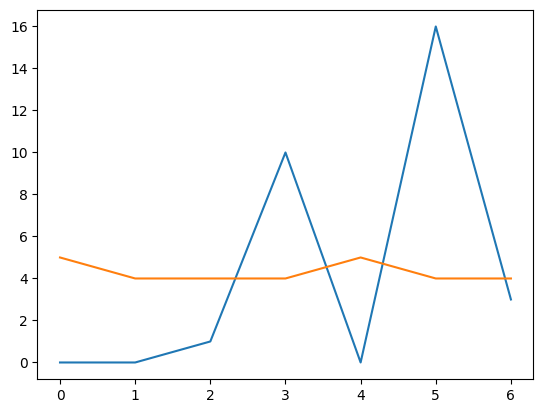

In [51]:
from utils.codec import CodecTransform
codec = CodecTransform(16000, bandwidth = 6.0)
# src = 'speeches'
# src = 'test_data_overheard/'
src = 'test_data_overheard_resampled/'
#src = 'speeches'
#_, sr = torchaudio.load(src + 'overheard_dylan.wav')

#model = LSTMNetwork(input_dim=15, hidden_dim=32, lstm_layers=1, linear_layers=[16, 7])
#model.load_state_dict(torch.load(params))
model.eval()
model = model.to(device)
test = RandomDataset(src, 16000, 30, codec, 8, 7)
testDl = DataLoader(test, batch_size=1)

correct = 0
total = 0
preds_distribution = np.zeros(7)
correct_distribution = np.zeros(7)
for input, target in testDl:
    input, target = input.to(device), target.to(device)
    #print(input.shape)
    #raise
    prediction = model(input)
    confidence, preds = torch.max(prediction.data, 1)

    if preds == target:
        correct += 1
    else:
        pass
        print(f'True label was {LABELS[target]}. Prediction was {LABELS[preds]} with {confidence.data} confidence')
    total += 1
    preds_distribution[preds.data] += 1
    correct_distribution[target.data] += 1

print('accuracy', correct/total)
plt.plot(preds_distribution)
plt.plot(correct_distribution)

In [17]:
# for f in os.listdir(src):
#     wav_filename = f'{f[:-4]}.wav'
#     AudioSegment.from_file(src + f, format = 'm4a').export(src + wav_filename, format = 'wav')

In [18]:
# wav, sr = torchaudio.load(src + 'overheard_dylan.wav')
# sr_new = 16000
# resampler = torchaudio.transforms.Resample(sr, sr_new, dtype = wav.dtype)
# src = 'test_data_overheard/'
# destination = src[:-1] + '_resampled/'
# for f in os.listdir(src):
#     if f[0] == '.':
#         continue
#     wav, _ = torchaudio.load(src + f)
#     resampled = resampler(wav)
#     torchaudio.save(destination + f, resampled, sr_new)

In [19]:
i = 7008
codec.cpu()
codes, label = dataSet[i]
wav = codec.decode(torch.tensor(codes).unsqueeze(0))
print(LABELS[label])
IPython.display.Audio(wav, rate=24000)


Dylan


In [18]:
test = RandomDataset(src, 16000, 1000, lambda x:x, 6, 5)
wav, label = test[180]
print(LABELS[label])
IPython.display.Audio(wav, rate=16000)


Kailash


In [118]:
amos : 0
kailash : 1
cyprian : 2